In [1]:
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


# Regular Training

In [2]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
import torch
from torch import optim
from dss.transformation import ResNetFeature
from dss.utils import train_model, test_model
from torchvision import datasets, transforms




class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.gelu(self.conv1(x)))
        x = self.pool(F.gelu(self.conv2(x)))
        x = self.pool(F.gelu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Flatten the output
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

class SimpleNet(nn.Module):
    def __init__(self, device='cuda'):
        super(SimpleNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 768),
            nn.GELU(),
            nn.Linear(768, 10)
        )
        self.device = device
        self.feature_map = ResNetFeature(device=device)

    def forward(self, x):
        x = self.feature_map(x)
        x = x.to(self.device)
        return self.fc(x)

/scratch/t.tovi/packages/dss/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


# Train Agent

In [4]:
from dss.env import CIFAR10Env
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv


In [5]:
env = DummyVecEnv([lambda: CIFAR10Env(use_raw=False)])

Files already downloaded and verified
Loading precomputed features...


In [6]:
from os import path

retrain = False
agent = PPO("MlpPolicy", env, verbose=0)
if path.exists("playground/ppo_cifar10.zip") and not retrain:
    agent = PPO.load("playground/ppo_cifar10.zip", env=env)
else:
    agent.learn(total_timesteps=int(1e5))
    agent.save("playground/ppo_cifar10")

/scratch/t.tovi/packages/dss/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [7]:
import tqdm

train_dataset = env.envs[0].dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

X = []
y = []
F = []
data_values = []
for state, feature, label in tqdm.tqdm(train_loader):
    _, log_likelihoods, _ = agent.policy.evaluate_actions(feature.to(0), torch.tensor([0, 1]).to(0))
    
    datum_value = log_likelihoods[1].cpu().item()

    X.append(state)
    y.append(label)
    F.append(feature)
    data_values.append(datum_value)

X = torch.cat(X)
y = torch.cat(y)
F = torch.cat(F)

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [02:30<00:00, 332.93it/s]


# Full Dataset Training

In [8]:
from dss.utils import SimpleDataset

train_dataset = SimpleDataset(X, y)
num_epochs = 10
batch_size = 64
learning_rate = 1e-3

model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_model(model, train_loader, criterion, optimizer, epochs=num_epochs, verbose=False)
test_model(model, test_dataset)

Test Accuracy: 86.90%


0.869

# Random Baseline

In [9]:
import numpy as np

mean_accs = []
eval_runs = 1
for limit in range(1, 11, 2):
    data_size = int(limit/100*len(X))
    epochs = int(100/limit) * 10
    print("Data size: ", data_size)

    indices = np.random.choice(X.shape[0], data_size, replace=False)
    X_subset = X[indices]
    y_subset = y[indices]
    accs = []
    for i in range(eval_runs):
        train_dataset = SimpleDataset(X_subset, y_subset)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Initialize model, optimizer, and environment
        model = SimpleNet()
        model.to('cuda')
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        train_model(model, train_loader, criterion, optimizer, epochs=epochs, verbose=True)
        
        acc = test_model(model, test_dataset)
        accs.append(acc)
    
    mean_accs.append(np.mean(accs))
    print(f'Limit: {limit}, Mean Accuracy: {np.mean(accs):.2f}')


Data size:  500


KeyboardInterrupt: 

> /ib-scratch/chenguang02/t.tovi/code/DSS-RL/dss/transformation.py(47)__call__()
     43         # Preprocess the image and encode it as a feature vector
     44         image = self.transform(image).to(self.device)
     45         with torch.no_grad():
     46             features = self.model(image)
---> 47         return features.squeeze((2, 3)).cpu()  # Flatten and convert to numpy array



# Max diversity

In [8]:
X_ = [x for x, _ in sorted(zip(X, data_values), key=lambda x: x[-1], reverse=True)]
y_ = [l for l, _ in sorted(zip(y, data_values), key=lambda x: x[-1], reverse=True)]
F_ = [f for f, _ in sorted(zip(F, data_values), key=lambda x: x[-1], reverse=True)]

In [9]:
mean_accs = []
eval_runs = 1
for limit in range(1, 101, 5):
    data_size = int(limit/100*len(X))
    epochs = int(100/limit) * 10
    print("Data size: ", data_size)

    X_subset = X_[:data_size]
    y_subset = y_[:data_size]
    accs = []
    for i in range(eval_runs):
        train_dataset = SimpleDataset(X_subset, y_subset)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Initialize model, optimizer, and environment
        model = SimpleNet()
        model.to('cuda')
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        train_model(model, train_loader, criterion, optimizer, epochs=epochs, verbose=True)
        
        acc = test_model(model, test_dataset)
        accs.append(acc)
    
    mean_accs.append(np.mean(accs))
    print(f'Limit: {limit}, Mean Accuracy: {np.mean(accs):.2f}')

Data size:  500


NameError: name 'SimpleDataset' is not defined

> /tmp/ipykernel_3674696/4018035734.py(12)<module>()
     10     accs = []
     11     for i in range(eval_runs):
---> 12         train_dataset = SimpleDataset(X_subset, y_subset)
     13         train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
     14 



# Min Diversity

In [ ]:
mean_accs = []
eval_runs = 1
for limit in range(1, 11, 2):
    data_size = int(limit/100*len(X))
    epochs = int(100/limit) * 10
    print("Data size: ", data_size)

    X_subset = X_[-data_size:]
    y_subset = y_[-data_size:]
    accs = []
    for i in range(eval_runs):
        train_dataset = SimpleDataset(X_subset, y_subset)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Initialize model, optimizer, and environment
        model = SimpleNet()
        model.to('cuda')
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        train_model(model, train_loader, criterion, optimizer, epochs=epochs, verbose=True)
        
        acc = test_model(model, test_dataset)
        accs.append(acc)
    
    mean_accs.append(np.mean(accs))
    print(f'Limit: {limit}, Mean Accuracy: {np.mean(accs):.2f}')

Data size:  500
Test Accuracy: 64.45%
Limit: 1, Mean Accuracy: 0.64
Data size:  1500


KeyboardInterrupt: 

> /ib-scratch/chenguang02/t.tovi/code/DSS-RL/dss/transformation.py(47)__call__()
     43         # Preprocess the image and encode it as a feature vector
     44         image = self.transform(image).to(self.device)
     45         with torch.no_grad():
     46             features = self.model(image)
---> 47         return features.squeeze((2, 3)).cpu()  # Flatten and convert to numpy array



# Diversity Measure

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

if isinstance(X_, list):
    X_ = torch.stack(X_)
    y_ = torch.stack(y_)
    F_ = torch.stack(F_)


In [ ]:
cosine_distances_random = []
covariances_random = []

for size in range(1, 52, 5):

    indices = np.random.choice(F.shape[0], int(size/100*len(F)), replace=False)
    samples = F_[indices]
    cosine_distances_random.append(np.mean(cosine_distances(samples.cpu().numpy())))
    covariances_random.append(np.trace(np.cov(samples.cpu().numpy().T)))

Size: 1, Covariance: 260.6442813754127
Size: 6, Covariance: 260.6442813754127
Size: 11, Covariance: 260.6442813754127
Size: 16, Covariance: 260.6442813754127
Size: 21, Covariance: 260.6442813754127
Size: 26, Covariance: 260.6442813754127
Size: 31, Covariance: 260.6442813754127
Size: 36, Covariance: 260.6442813754127
Size: 41, Covariance: 260.6442813754127
Size: 46, Covariance: 260.6442813754127
Size: 51, Covariance: 260.6442813754127


In [29]:
cosine_distances_max = []
covariances_max = []

for size in range(1, 52, 5):

    indices = torch.arange(int(size/100*len(F_)))
    samples = F_[indices]
    cosine_distances_max.append(np.mean(cosine_distances(samples.cpu().numpy())))
    covariances_max.append(np.trace(np.cov(samples.cpu().numpy().T)))

In [23]:
cosine_distances_min = []
covariances_min = []

for size in range(1, 52, 5):

    indices = torch.arange(int(size/100*len(F_)))
    samples = F_[-indices]
    cosine_distances_min.append(np.mean(cosine_distances(samples.cpu().numpy())))
    covariances_min.append(np.trace(np.cov(samples.cpu().numpy().T)))

In [13]:
import math

def dpp(kernel_matrix, max_length, epsilon=1E-10):
    """
    Our proposed fast implementation of the greedy algorithm
    :param kernel_matrix: 2-d array
    :param max_length: positive int
    :param epsilon: small positive scalar
    :return: list
    """
    item_size = kernel_matrix.shape[0]
    cis = np.zeros((max_length, item_size))
    di2s = np.copy(np.diag(kernel_matrix))
    selected_items = list()
    selected_item = np.argmax(di2s)
    selected_items.append(selected_item)
    while len(selected_items) < max_length:
        k = len(selected_items) - 1
        ci_optimal = cis[:k, selected_item]
        di_optimal = math.sqrt(di2s[selected_item])
        elements = kernel_matrix[selected_item, :]
        eis = (elements - np.dot(ci_optimal, cis[:k, :])) / di_optimal
        cis[k, :] = eis
        di2s -= np.square(eis)
        di2s[selected_item] = -np.inf
        selected_item = np.argmax(di2s)
        if di2s[selected_item] < epsilon:
            break
        selected_items.append(selected_item)

        #print(f"Progress: {len(selected_items)}/{max_length}")
    return selected_items

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

kernel_matrix = rbf_kernel(F_.cpu().numpy(), gamma=1e-3)

In [15]:
max_size = int(0.51 * len(X_))
selected_indices = dpp(kernel_matrix, max_size)

In [35]:
cosine_distances_dpp = []
covariances_dpp = []

size = 500
for i in range(11):
    size_ = size + i * 2500
    samples = F_[selected_indices[:size_]]
    cosine_distances_dpp.append(np.mean(cosine_distances(samples.cpu().numpy())))
    covariances_dpp.append(np.trace(np.cov(samples.cpu().numpy().T)))

In [ ]:
# DSS-RL 3 minutes + 2.5 minutes
# Greedy DPP 81 minutues

# Make the plot

In [25]:
import matplotlib.pyplot as plt

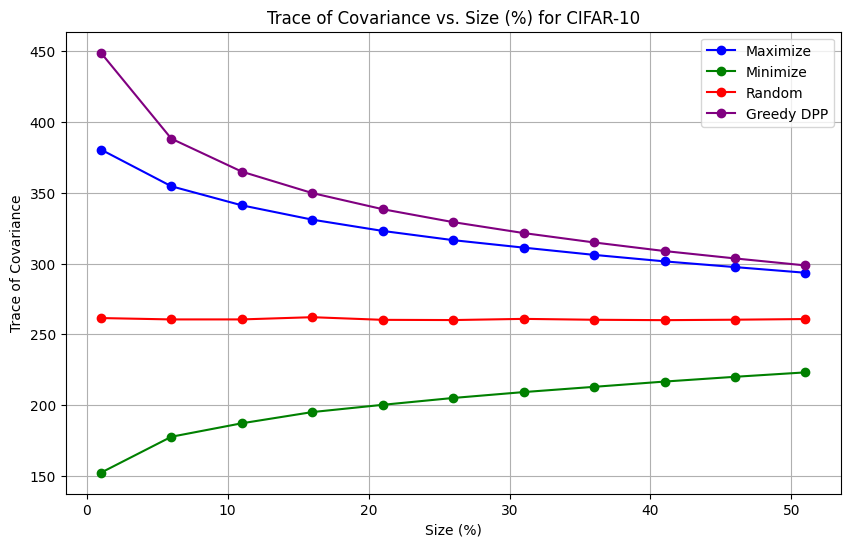

In [39]:
sizes = range(1, 52, 5)

plt.figure(figsize=(10, 6))
plt.plot(sizes, covariances_max, marker='o', linestyle='-', color='b', label='Maximize')
plt.plot(sizes, covariances_min, marker='o', linestyle='-', color='g', label='Minimize')
plt.plot(sizes, covariances_random, marker='o', linestyle='-', color='r', label='Random')
plt.plot(sizes, covariances_dpp, marker='o', linestyle='-', color='purple', label='Greedy DPP')

# Updating labels and title for the plot
plt.xlabel('Size (%)')
plt.ylabel('Trace of Covariance')
plt.title('Trace of Covariance vs. Size (%) for CIFAR-10')
plt.legend()
plt.grid(True)
plt.show()

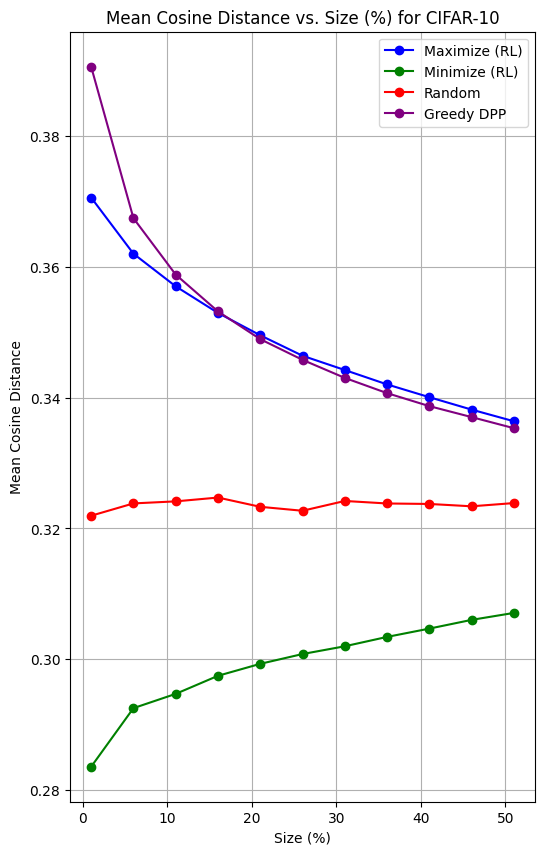

In [42]:
sizes = range(1, 52, 5)

plt.figure(figsize=(6, 10))
plt.plot(sizes, cosine_distances_max, marker='o', linestyle='-', color='b', label='Maximize (RL)')
plt.plot(sizes, cosine_distances_min, marker='o', linestyle='-', color='g', label='Minimize (RL)')
plt.plot(sizes, cosine_distances_random, marker='o', linestyle='-', color='r', label='Random')
plt.plot(sizes, cosine_distances_dpp, marker='o', linestyle='-', color='purple', label='Greedy DPP')

# Updating labels and title for the plot
plt.xlabel('Size (%)')
plt.ylabel('Mean Cosine Distance')
plt.title('Mean Cosine Distance vs. Size (%) for CIFAR-10')
plt.legend()
plt.grid(True)
plt.show()